# 2013 Coal Prediction

by: Jonathan Whitmore

In [1]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from sklearn.cross_validation import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import explained_variance_score, r2_score, mean_squared_error

sns.set();

/Users/jbw/anaconda/lib/python2.7/site-packages/matplotlib/__init__.py:872: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


## Cleaned Data

We cleaned the data in the Data_cleaning.ipynb file in the deliver directory.

In [2]:
df = pd.read_csv("../data/cleaned_coalpublic2013.csv", index_col='MSHA ID')
df[["Mine_Name", "Company_Type"]].head()

,Mine_Name,Company_Type
MSHA ID,,
103381,Tacoa Highwall Miner,Independent Producer Operator
103404,Reid School Mine,Independent Producer Operator
100759,North River #1 Underground Min,Independent Producer Operator
103246,Bear Creek,Independent Producer Operator
103451,Knight Mine,Independent Producer Operator


# Predict the Production of coal mines

In [3]:
features = ['Average_Employees',
            'Labor_Hours',
           ]

categoricals = ['Mine_State',
                'Mine_County',
                'Mine_Status',
                'Mine_Type',
                'Company_Type',
                'Operation_Type',
                'Union_Code',
                'Coal_Supply_Region',
               ]

target = 'log_production'

/Users/jbw/anaconda/lib/python2.7/site-packages/matplotlib/__init__.py:892: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


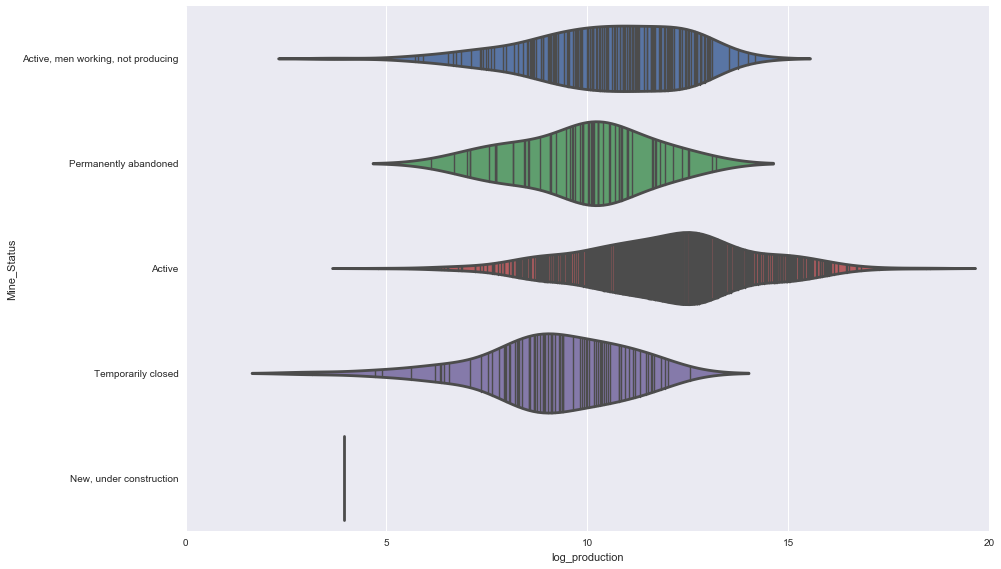

In [4]:
fig = plt.subplots(figsize=(14,8))
sns.set_context('poster')
sns.violinplot(y="Mine_Status", x="log_production", data=df,
               split=True, inner="stick", )
plt.tight_layout()
plt.savefig("../figures/Coal-production-Mine_status-vs-log_production.png")

Avoid the dummy variable trap! Below I create the dummy_categoricals variable, and to encode this correctly, we have to do something subtle, so pay attention to how we drop the column!

In [5]:
dummy_categoricals = []
for categorical in categoricals:
    print categorical, len(df[categorical].unique())
    drop_var = sorted(df[categorical].unique())[-1]
    temp_df = pd.get_dummies(df[categorical], prefix=categorical)
    df = pd.concat([df, temp_df], axis=1)
    temp_df.drop('_'.join([categorical, str(drop_var)]), axis=1, inplace=True)
    dummy_categoricals += temp_df.columns.tolist()

Mine_State 29
Mine_County 164
Mine_Status 5
Mine_Type 3
Company_Type 3
Operation_Type 2
Union_Code 7
Coal_Supply_Region 8


# Model

In [6]:
train, test = train_test_split(df, test_size=0.3)
rf = RandomForestRegressor(n_estimators=100, oob_score=True)
rf.fit(train[features + dummy_categoricals], train[target])

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=100, n_jobs=1, oob_score=True, random_state=None,
           verbose=0, warm_start=False)

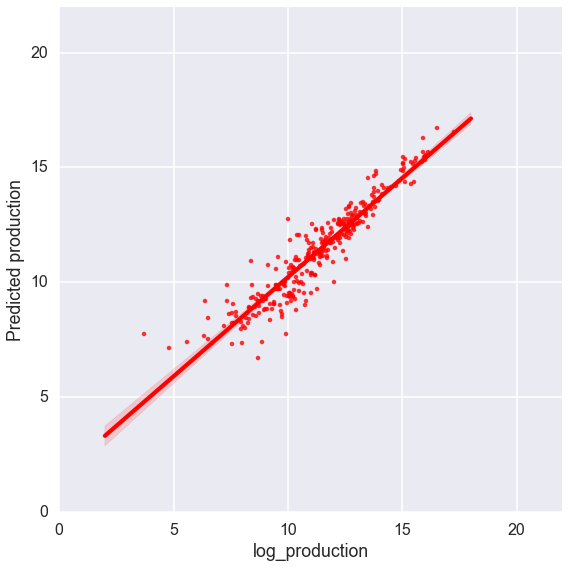

In [7]:
fig = plt.subplots(figsize=(8,8))
sns.regplot(test[target], rf.predict(test[features + dummy_categoricals]), color='red')
plt.ylabel("Predicted production")
plt.xlim(0, 22)
plt.ylim(0, 22)
plt.tight_layout()
plt.savefig("../figures/Coal-production-RF-prediction.png")

In [8]:
predicted = rf.predict(test[features + dummy_categoricals])

print "R2 score:", r2_score(test[target], predicted)
print "Explained variance score:", explained_variance_score(test[target], predicted)
print "MSE:", mean_squared_error(test[target], predicted)

R2 score: 0.881669623831
Explained variance score: 0.881890029359
MSE: 0.59355899904


In [9]:
rf_importances = pd.DataFrame({'name':train[features + dummy_categoricals].columns,
                               'importance':rf.feature_importances_
                              }).sort_values(by='importance', 
                                              ascending=False).reset_index(drop=True)
rf_importances.head(20)

,importance,name
0,0.798733,Labor_Hours
1,0.096827,Average_Employees
2,0.009454,Mine_Type_Surface
3,0.008344,Coal_Supply_Region_Powder River Basin
4,0.005430,Mine_County_Campbell
5,0.004654,Mine_State_West Virginia (Southern)
6,0.004480,Mine_Status_Active
7,0.003186,Coal_Supply_Region_Illinois Basin
8,0.003137,Coal_Supply_Region_Appalachia Central
9,0.003127,Mine_County_Boone


# Conclusions

This is where amazing writeup of the profound conclusions go!